In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from BackTest_Toolkit import FactorGroup, FactorPurify, IndustryNeutralize, simple_factor_test, plot_factor_performance

In [2]:
df_inst = pd.read_excel('中证500资金流动.xlsx', sheet_name="extra_large", header=1)
df_inst.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df_inst['Date'] = pd.to_datetime(df_inst['Date'], format='%Y-%m-%d')
df_inst.set_index('Date', inplace=True)
df_inst.apply(pd.to_numeric, errors='coerce')
print(df_inst.tail())

df_retail = pd.read_excel('中证500资金流动.xlsx', sheet_name="small", header=1)
df_retail.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df_retail['Date'] = pd.to_datetime(df_retail['Date'], format='%Y-%m-%d')
df_retail.set_index('Date', inplace=True)
df_retail.apply(pd.to_numeric, errors='coerce')
print(df_retail.tail())


            000009.SZ  000021.SZ  000027.SZ  000032.SZ  000034.SZ  000039.SZ  \
Date                                                                           
2025-07-07   19424820  -41342979     986610  -30855985  -40400502   -4591407   
2025-07-08   16381960  150250584   11208918    4652622   31561305   -7004899   
2025-07-09   -9886315  -54923828  -12035330   -2982756  -28340466    9743689   
2025-07-10    9701932  -24872198   -5546287    3820462   33930783    6380229   
2025-07-11   18143673  -17091409   -1016406   88980669   51317809  -11367735   

            000050.SZ  000060.SZ  000062.SZ  000066.SZ  ...  688608.SH  \
Date                                                    ...              
2025-07-07    1015750  -14388166   11329873   -8983340  ...  -48840457   
2025-07-08    1047193    -988228  -31312983   16357022  ...   17988852   
2025-07-09    4558663   -2655954  -15101826  -50959930  ...    -284227   
2025-07-10   11493735    8252324  -10813920  -22389309  ...    456205

In [3]:
df_industry = pd.read_excel('行业代码500.xlsx', sheet_name="申万", header=0)
print(df_industry.head())

df_total_cap = pd.read_excel('中证500市值.xlsx', sheet_name="total_cap", header=1)
df_total_cap.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df_total_cap['Date'] = pd.to_datetime(df_total_cap['Date'], format='%Y-%m-%d')
df_total_cap.set_index('Date', inplace=True)
df_total_cap.apply(pd.to_numeric, errors='coerce')
df_total_cap = df_total_cap.map(lambda x: np.log(x) if x > 0 else np.nan)
df_total_cap_monthly = df_total_cap.resample('ME').last()
print(df_total_cap.head())
print(df_total_cap_monthly.head())


        Code    Industry
0  000009.SZ  801730.SWI
1  000021.SZ  801080.SWI
2  000027.SZ  801160.SWI
3  000032.SZ  801720.SWI
4  000034.SZ  801750.SWI
            000009.SZ  000021.SZ  000027.SZ  000032.SZ  000034.SZ  000039.SZ  \
Date                                                                           
2014-01-02  23.190603  22.788349  23.394457  21.447513  21.133432  24.442041   
2014-01-03  23.163648  22.780858  23.370404  21.436162  21.138172  24.457426   
2014-01-06  23.154866  22.788349  23.347676  21.402497  21.104515  24.423788   
2014-01-07  23.152659  22.833935  23.343837  21.374967  21.111823  24.453602   
2014-01-08  23.134821  22.851604  23.355309  21.396576  21.074736  24.449122   

            000050.SZ  000060.SZ  000062.SZ  000066.SZ  ...  688608.SH  \
Date                                                    ...              
2014-01-02  22.616104  23.284768  22.793923  22.364593  ...        NaN   
2014-01-03  22.616969  23.284768  22.831881  22.369708  ...        

In [4]:
df_close = pd.read_excel('中证500.xlsx', sheet_name="close", header=1)
df_close.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df_close['Date'] = pd.to_datetime(df_close['Date'], format='%Y-%m-%d')  
df_close.set_index('Date', inplace=True)
df_close.apply(pd.to_numeric, errors='coerce')
print(df_close)

ret_close = df_close.pct_change().resample('ME').mean()  # 每月收益率

            000009.SZ  000021.SZ  000027.SZ  000032.SZ  000034.SZ  000039.SZ  \
Date                                                                           
2014-01-02   4.684113   4.879978   2.350680   7.053180   3.849812   6.856300   
2014-01-03   4.559535   4.843560   2.294813   6.973573   3.868101   6.962599   
2014-01-06   4.519670   4.879978   2.243244   6.742713   3.740079   6.732284   
2014-01-07   4.509704   5.107589   2.234650   6.559617   3.767512   6.936024   
2014-01-08   4.429975   5.198633   2.260434   6.702909   3.630345   6.905020   
...               ...        ...        ...        ...        ...        ...   
2025-06-24   8.810000  17.540000   6.330000  19.270000  36.780000   7.840000   
2025-06-25   8.880000  18.100000   6.430000  20.190000  37.480000   7.860000   
2025-06-26   8.920000  18.260000   6.440000  20.120000  37.340000   7.870000   
2025-06-27   8.800000  18.500000   6.410000  20.030000  37.490000   7.870000   
2025-06-30   8.880000  18.740000   6.380

In [5]:
def calc_monthly_spearman(df_inst, df_retail, N=20):
    """
    计算每月每只股票超大单和小单在过去N个交易日同步净流入的秩相关系数。
    返回一个MultiIndex DataFrame: index=(月份, 股票代码), columns=['Correlation', 'P-Value']
    """
    results = []
    # 确保索引为DatetimeIndex
    df_inst = df_inst.copy()
    df_retail = df_retail.copy()
    df_inst.index = pd.to_datetime(df_inst.index)
    df_retail.index = pd.to_datetime(df_retail.index)
    # 取交集，保证对齐
    common_dates = df_inst.index.intersection(df_retail.index)
    df_inst = df_inst.loc[common_dates]
    df_retail = df_retail.loc[common_dates]
    # 按月分组
    months = df_inst.index.to_period('M').unique()
    for month in months:
        # 取该月最后一个交易日
        month_end = df_inst[df_inst.index.to_period('M') == month].index.max()
        if month_end is None:
            continue
        # 取过去N个交易日
        idx = df_inst.index.get_loc(month_end)
        if idx < N - 1:
            continue  # 不足N天跳过
        period_idx = df_inst.index[idx - N + 1: idx + 1]
        inst_period = df_inst.loc[period_idx]
        retail_period = df_retail.loc[period_idx]
        for stock in df_inst.columns:
            inst_flow = inst_period[stock]
            retail_flow = retail_period[stock]

            if inst_flow.isnull().all() or retail_flow.isnull().all():
                continue
            if (inst_flow == 0).all() or (retail_flow == 0).all():
                continue
            # 计算秩相关
            corr, pval = spearmanr(inst_flow, retail_flow, nan_policy='omit')
            results.append({
                'Date': month.strftime('%Y-%m-%d'),
                'Code': stock,
                'Correlation': corr,
                'P-Value': pval
            })
    res_df = pd.DataFrame(results)
    return res_df


monthly_corr = calc_monthly_spearman(df_inst, df_retail, N=20)
monthly_corr.drop(columns=['P-Value'], inplace=True)
print(monthly_corr)
monthly_corr_df = monthly_corr.pivot(index='Date', columns='Code', values='Correlation')
monthly_corr_df.index = pd.to_datetime(monthly_corr_df.index, format='%Y-%m-%d')
monthly_corr_df = monthly_corr_df[:-1]
print(monthly_corr_df.tail())


             Date       Code  Correlation
0      2014-01-31  000009.SZ    -0.503759
1      2014-01-31  000021.SZ    -0.756391
2      2014-01-31  000027.SZ    -0.563653
3      2014-01-31  000032.SZ    -0.045960
4      2014-01-31  000039.SZ    -0.828571
...           ...        ...          ...
56008  2025-07-31  688772.SH    -0.320301
56009  2025-07-31  688777.SH    -0.320301
56010  2025-07-31  688778.SH    -0.114286
56011  2025-07-31  688819.SH    -0.416541
56012  2025-07-31  689009.SH    -0.347368

[56013 rows x 3 columns]
Code        000009.SZ  000021.SZ  000027.SZ  000032.SZ  000034.SZ  000039.SZ  \
Date                                                                           
2025-02-28  -0.222556  -0.827068  -0.109774  -0.852632  -0.437594  -0.666165   
2025-03-31  -0.482707  -0.908271  -0.151880  -0.679699  -0.932331  -0.592481   
2025-04-30  -0.187970  -0.861654  -0.479699  -0.538346  -0.795489  -0.580451   
2025-05-31  -0.412030  -0.870677  -0.610526  -0.481203  -0.932331  -0.

In [6]:
# 极值处理：用MAD法替换异常值
M_rankcorr20 = monthly_corr_df.apply(
    lambda x: x.clip(
        lower=x.median() - 3 * (1.4826 * (x - x.median()).abs().median()),
        upper=x.median() + 3 * (1.4826 * (x - x.median()).abs().median())
    )
)

# # 市值中性化处理
# M_rankcorr20 = FactorPurify(M_rankcorr20, [df_total_cap_monthly])
# # 行业中性化处理
# M_rankcorr20 = IndustryNeutralize(M_rankcorr20, df_industry)



print(M_rankcorr20.tail())

Code        000009.SZ  000021.SZ  000027.SZ  000032.SZ  000034.SZ  000039.SZ  \
Date                                                                           
2025-02-28  -0.416740  -0.827068  -0.109774  -0.852632  -0.437594  -0.666165   
2025-03-31  -0.482707  -0.908271  -0.151880  -0.679699  -0.932331  -0.592481   
2025-04-30  -0.416740  -0.861654  -0.479699  -0.538346  -0.795489  -0.580451   
2025-05-31  -0.416740  -0.870677  -0.610526  -0.481203  -0.932331  -0.851128   
2025-06-30  -0.512782  -0.781955  -0.523308  -0.806015  -0.813534  -0.493233   

Code        000050.SZ  000060.SZ  000062.SZ  000066.SZ  ...  688608.SH  \
Date                                                    ...              
2025-02-28  -0.413534  -0.378947  -0.730827  -0.962406  ...  -0.574436   
2025-03-31  -0.236599  -0.339850  -0.813534  -0.921805  ...   0.124812   
2025-04-30  -0.436090  -0.754887  -0.712782  -0.816541  ...   0.117293   
2025-05-31  -0.236599   0.061654  -0.905263  -0.932331  ...  -0.17443

------------------------------------------------------------
IC Mean: 3.45%,
 IC Std: 10.54%
Rank IC Mean: 6.24%,
 Rank IC Std: 11.23%
IC t-stat: 3.83
IC > 0 Win Rate: 62.32%
IR: 0.33
------------------------------------------------------------
group_id         0.0       1.0       2.0       3.0       4.0       5.0  \
date                                                                     
2014-01-31  0.003814  0.000360  0.000606  0.000705  0.003501  0.003957   
2014-02-28 -0.004198 -0.002180 -0.003063 -0.001184 -0.002461 -0.002114   
2014-03-31 -0.000922 -0.000940 -0.000619 -0.000324 -0.000227 -0.003272   
2014-04-30  0.000342  0.001228  0.001515  0.000531  0.001367  0.002961   
2014-05-31  0.002041  0.002599  0.001505  0.001711  0.001069  0.003210   
...              ...       ...       ...       ...       ...       ...   
2025-01-31  0.007074  0.004355  0.002395  0.003903  0.002113  0.001194   
2025-02-28 -0.001571 -0.000360  0.000026  0.000082  0.001908 -0.000257   
2025-03-31 -0.0

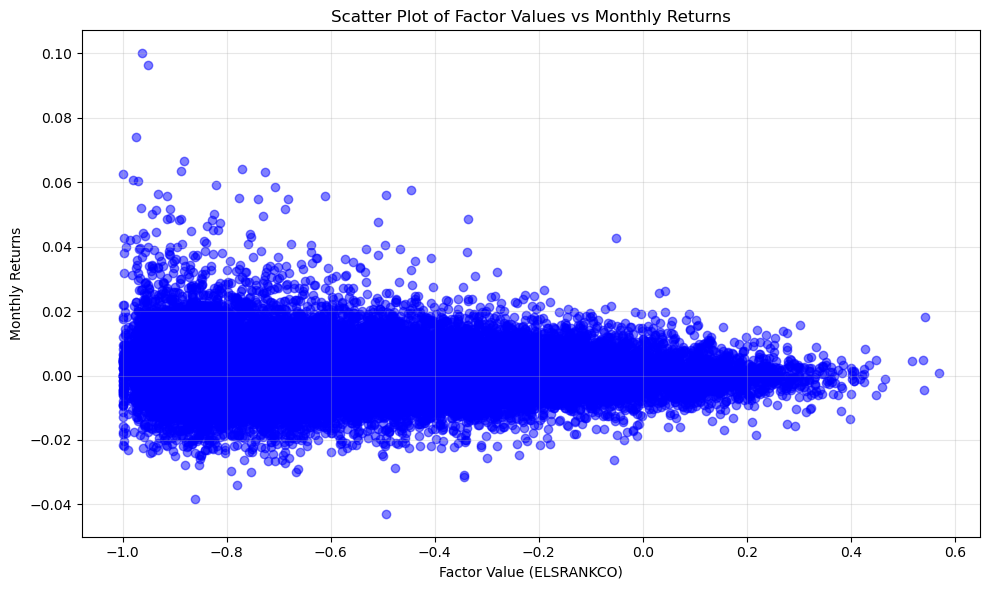

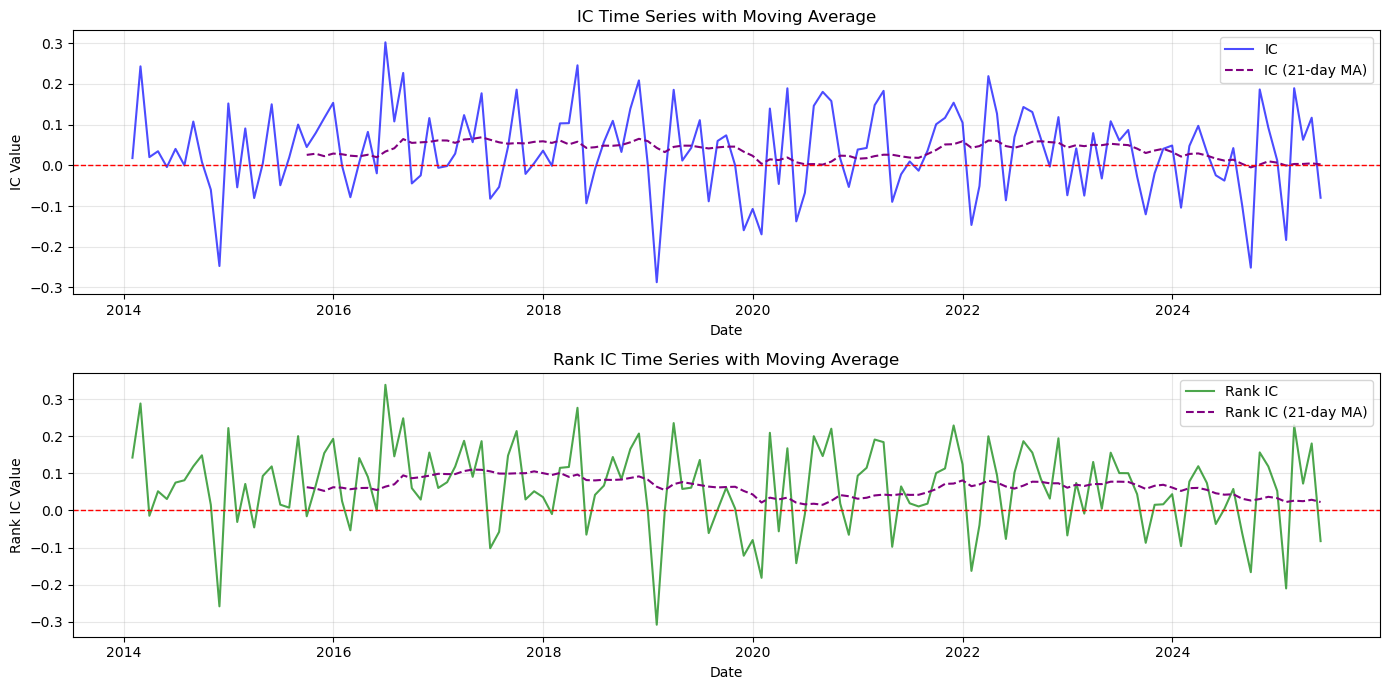

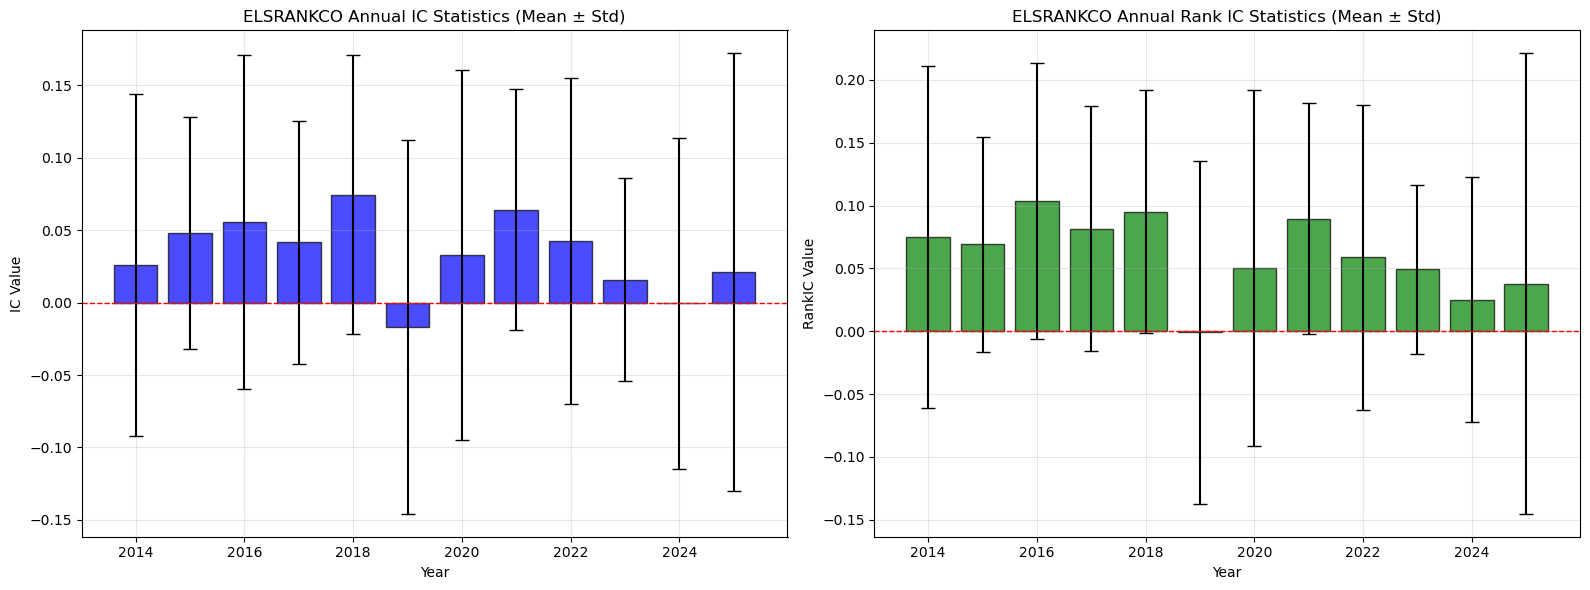

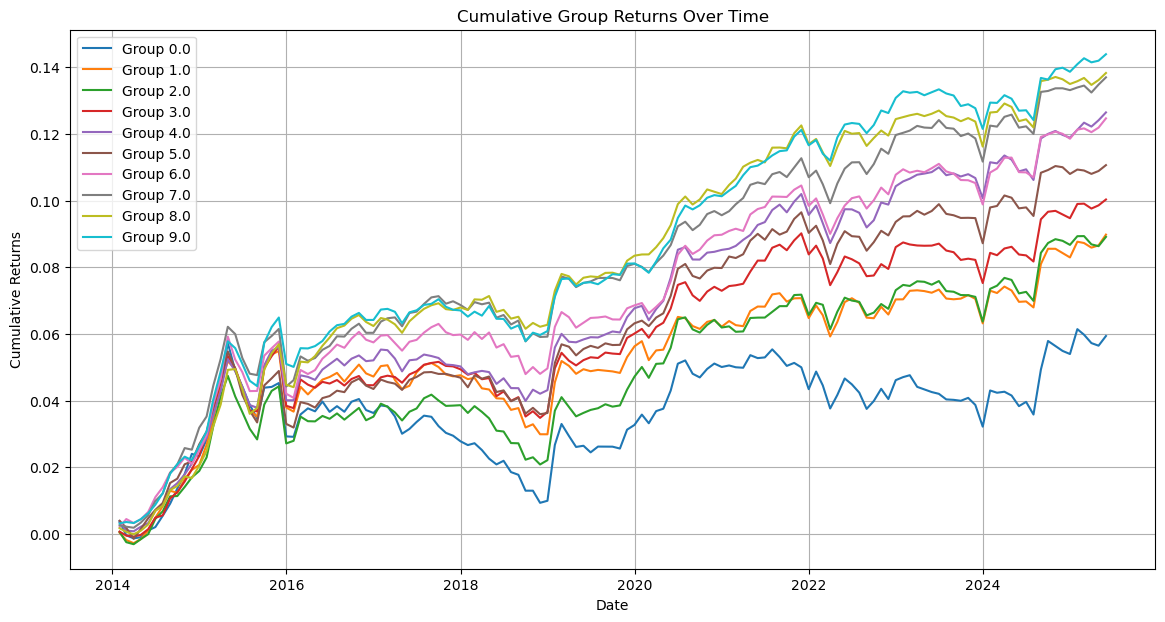

Long position: Group 9.0
Short position: Group 0.0


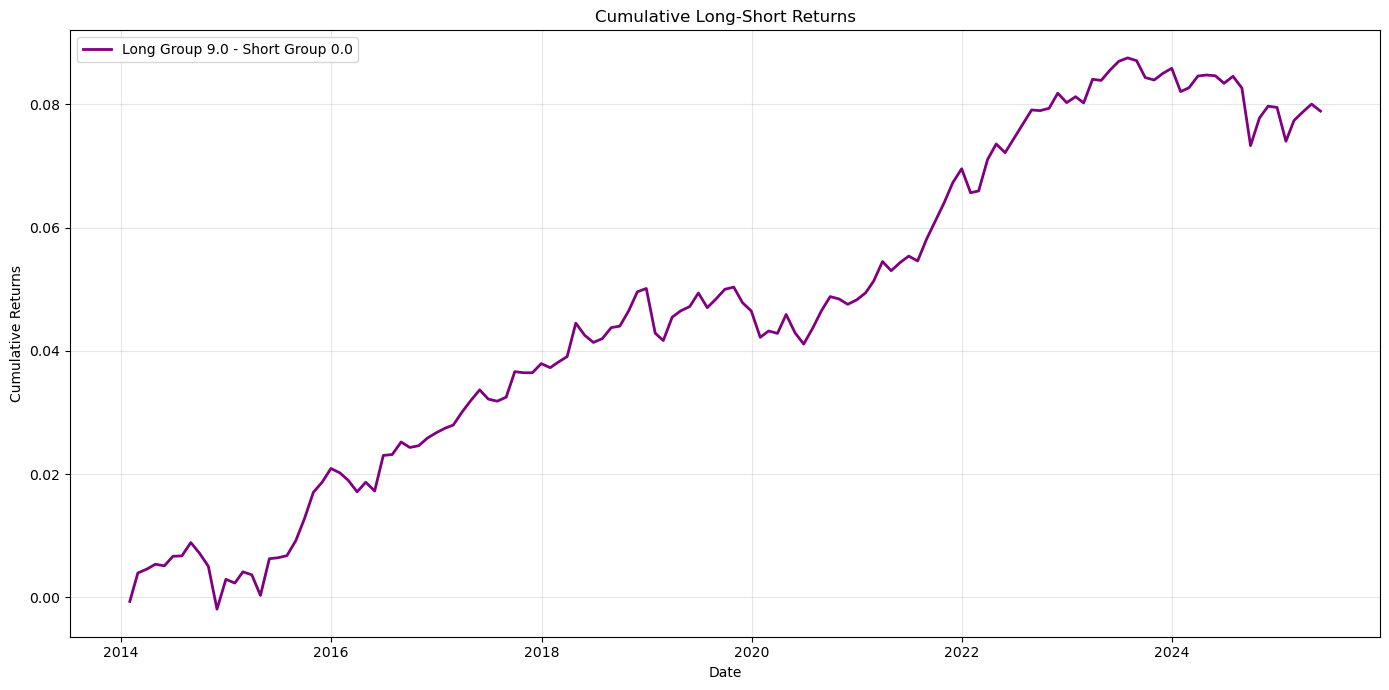

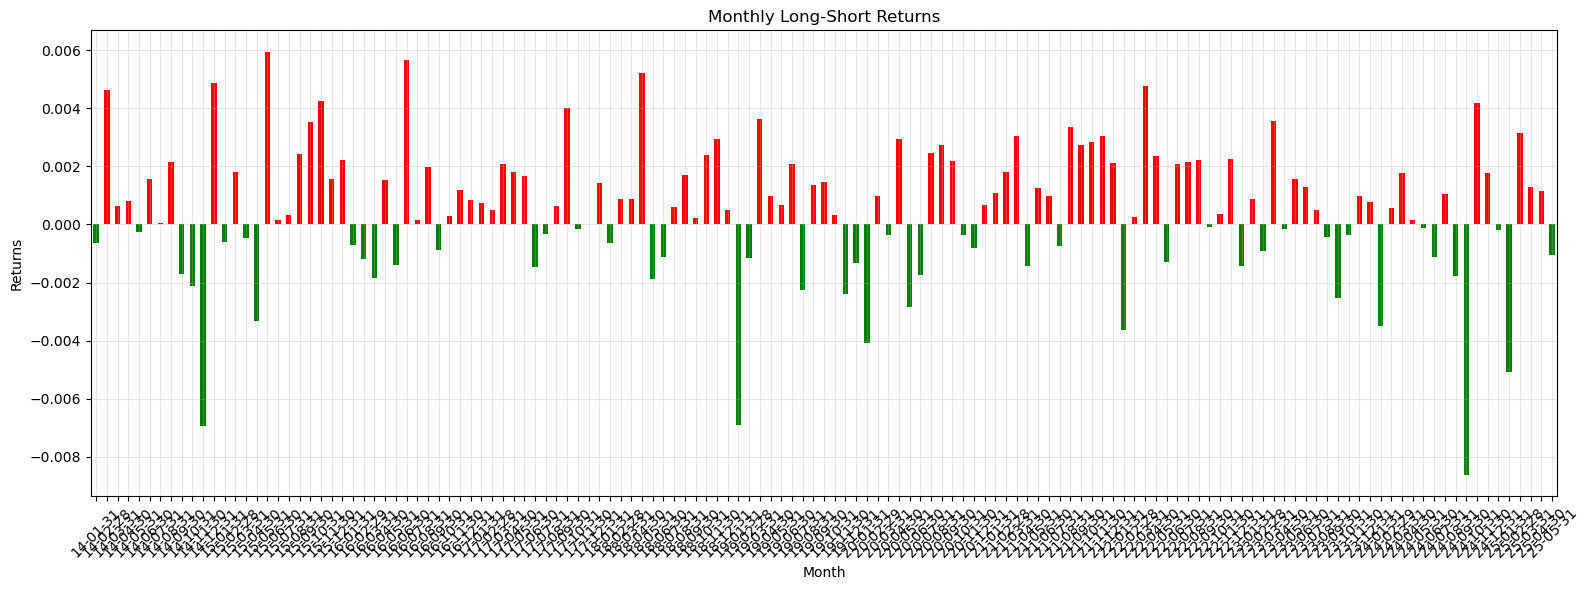

------------------------------------------------------------
Annual Return: 14.04%
Annual Volatility: 3.71%
Sharpe Ratio: 3.79
Max Drawdown: 1.42%
------------------------------------------------------------


In [7]:
ELSRANKCO = M_rankcorr20.copy()
ELSRANKCO.name = 'ELSRANKCO'

ic1, rankic1, group_ret1 = simple_factor_test(ELSRANKCO, ret_close, 10)

plot_factor_performance(ELSRANKCO, ret_close, ic1, rankic1, group_ret1)

In [8]:
def calc_monthly_lagged_spearman(df, lag=1, N=20):
    """
    计算每月每只股票小单在过去N个交易日与其滞后lag天净流入的秩相关系数。
    返回一个DataFrame: index=(月份, 股票代码), columns=['Correlation', 'P-Value']
    
    参数:
    df: 数据框，包含小单资金流数据
    lag: 滞后天数
    N: 计算窗口大小（天数）
    """
    results = []
    # 确保索引为DatetimeIndex
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    
    # 按月分组
    months = df.index.to_period('M').unique()
    for month in months:
        # 取该月最后一个交易日
        month_end = df[df.index.to_period('M') == month].index.max()
        if month_end is None:
            continue
        # 取过去N个交易日
        idx = df.index.get_loc(month_end)
        if idx < N + lag - 1:  # 需要额外的lag天进行计算
            continue  # 不足N+lag天跳过
        
        period_idx = df.index[idx - N - lag + 1: idx + 1]
        flow_period = df.loc[period_idx]
        
        for stock in df.columns:
            flow = flow_period[stock]
            
            if flow.isnull().all() or len(flow) < N + lag:
                continue
            if (flow == 0).all():
                continue
            
            # 原始序列和滞后序列
            original_flow = flow.iloc[lag:]
            lagged_flow = flow.iloc[:-lag]
            
            if len(original_flow) < N or len(lagged_flow) < N:
                continue
                
            # 使用最后N天数据计算相关性
            original_flow = original_flow.iloc[-N:]
            lagged_flow = lagged_flow.iloc[-N:]
            
            # 计算秩相关
            corr, pval = spearmanr(original_flow, lagged_flow, nan_policy='omit')
            
            results.append({
                'Date': month.strftime('%Y-%m-%d'),
                'Code': stock,
                'Correlation': corr,
                'P-Value': pval
            })
    
    res_df = pd.DataFrame(results)
    return res_df

# 计算小单资金流与其滞后1天的相关性
lagged_corr = calc_monthly_lagged_spearman(df_retail, lag=1, N=20)
print(lagged_corr.head())

# 转换为透视表格式
lagged_corr_df = lagged_corr.pivot(index='Date', columns='Code', values='Correlation')
lagged_corr_df.index = pd.to_datetime(lagged_corr_df.index, format='%Y-%m-%d')
lagged_corr_df = lagged_corr_df[:-1]  # 去掉最后一行，因为它可能不完整
print(lagged_corr_df.tail())



C:\Users\15799\AppData\Local\Temp\ipykernel_29928\1799821249.py:51: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = spearmanr(original_flow, lagged_flow, nan_policy='omit')


         Date       Code  Correlation   P-Value
0  2014-01-31  000009.SZ     0.469173  0.036897
1  2014-01-31  000021.SZ     0.060150  0.801113
2  2014-01-31  000027.SZ     0.263158  0.262287
3  2014-01-31  000032.SZ    -0.112782  0.635917
4  2014-01-31  000034.SZ    -0.073684  0.757529
Code        000009.SZ  000021.SZ  000027.SZ  000032.SZ  000034.SZ  000039.SZ  \
Date                                                                           
2025-02-28   0.213534  -0.437594   0.055639  -0.016541   0.312782   0.118797   
2025-03-31  -0.133835  -0.162406  -0.109774   0.233083   0.100752   0.290226   
2025-04-30   0.285714   0.120301   0.312782   0.100752   0.306767  -0.166917   
2025-05-31  -0.066165   0.219549   0.291729   0.393985   0.096241  -0.233083   
2025-06-30  -0.269173   0.257143  -0.141353   0.196992   0.270677   0.368421   

Code        000050.SZ  000060.SZ  000062.SZ  000066.SZ  ...  688608.SH  \
Date                                                    ...              
202

In [9]:
# 极值处理：用MAD法替换异常值
M_lagged_corr = lagged_corr_df.apply(
    lambda x: x.clip(
        lower=x.median() - 3 * (1.4826 * (x - x.median()).abs().median()),
        upper=x.median() + 3 * (1.4826 * (x - x.median()).abs().median())
    )
)

# 市值中性化处理
M_lagged_corr = FactorPurify(M_lagged_corr, [df_total_cap_monthly])
# 行业中性化处理
M_lagged_corr = IndustryNeutralize(M_lagged_corr, df_industry)
print(M_lagged_corr.tail())

d:\Sherlock\Internship\SMS intern\Factor_BackTest\BackTest_Toolkit.py:151: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  factor_res = pd.concat([factor_res, res.resid.rename(idx)], axis=1)


           000009.SZ 000021.SZ 000027.SZ 000032.SZ 000034.SZ 000039.SZ  \
2025-02-28  0.183254 -0.483669  0.011993 -0.060679  0.264224  0.057396   
2025-03-31 -0.210615 -0.221499 -0.166893  0.167898  0.041979  0.257391   
2025-04-30  0.125613 -0.032764  0.161565  -0.05399  0.154513 -0.312019   
2025-05-31 -0.107638  0.169598  0.237401  0.350382  0.046992 -0.296958   
2025-06-30  -0.35315  0.170378 -0.228542  0.112957   0.18492  0.277424   

           000050.SZ 000060.SZ 000062.SZ 000066.SZ  ... 688249.SH 688361.SH  \
2025-02-28  0.023642 -0.075476  0.457676  0.042021  ... -0.260577  0.082657   
2025-03-31  0.340705 -0.158454 -0.021453 -0.229113  ...  0.150687  0.238944   
2025-04-30 -0.288293 -0.267655  0.104741  0.000922  ... -0.338049  0.489789   
2025-05-31  0.124696  0.159485 -0.221872 -0.108293  ... -0.500835  0.304671   
2025-06-30 -0.072428 -0.008476  0.021964  0.082081  ...   0.01925  0.321633   

           688469.SH 688563.SH 688582.SH 301498.SZ 688702.SH 301536.SZ  \
2025-0

------------------------------------------------------------
IC Mean: 3.12%,
 IC Std: 8.25%
Rank IC Mean: 2.62%,
 Rank IC Std: 7.32%
IC t-stat: 4.43
IC > 0 Win Rate: 60.14%
IR: 0.38
------------------------------------------------------------
group_id         0.0       1.0       2.0       3.0       4.0       5.0  \
date                                                                     
2014-01-31  0.001475  0.002207  0.003596  0.001313  0.001390  0.002694   
2014-02-28 -0.001519 -0.004087  0.000305 -0.001744 -0.000126 -0.002051   
2014-03-31 -0.001083  0.000312 -0.001595 -0.000815 -0.000599 -0.001438   
2014-04-30  0.001800  0.000863  0.002225  0.002113  0.001263  0.001089   
2014-05-31  0.002765  0.001275  0.002047  0.001927  0.002319  0.002344   
...              ...       ...       ...       ...       ...       ...   
2025-01-31  0.003664  0.001671  0.003769  0.002591  0.003463  0.000844   
2025-02-28  0.000234  0.000353 -0.000277 -0.000476 -0.000184  0.000087   
2025-03-31 -0.001

d:\Sherlock\Internship\SMS intern\Factor_BackTest\BackTest_Toolkit.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  factor1.replace({None:np.nan},inplace=True)


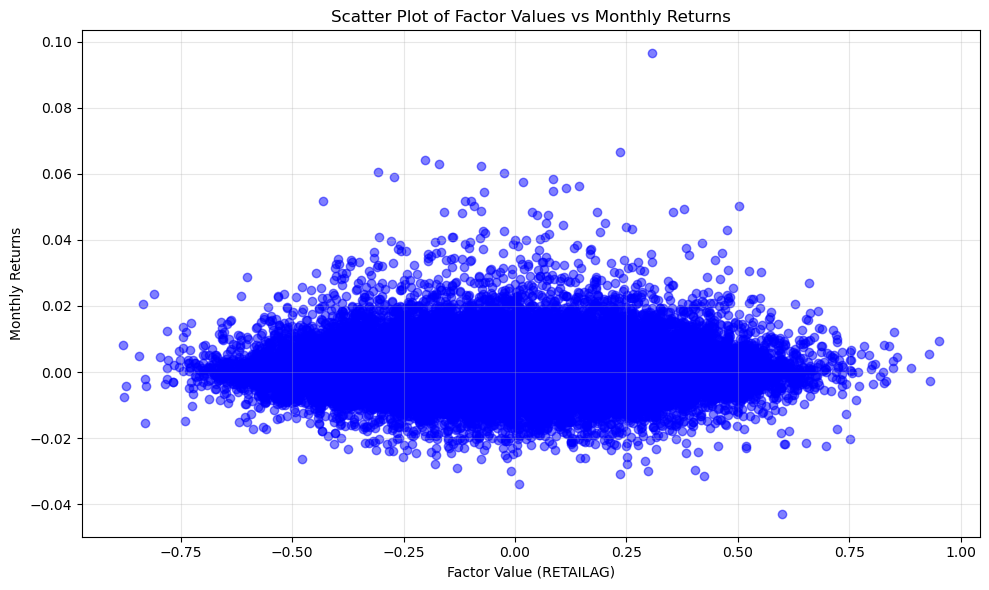

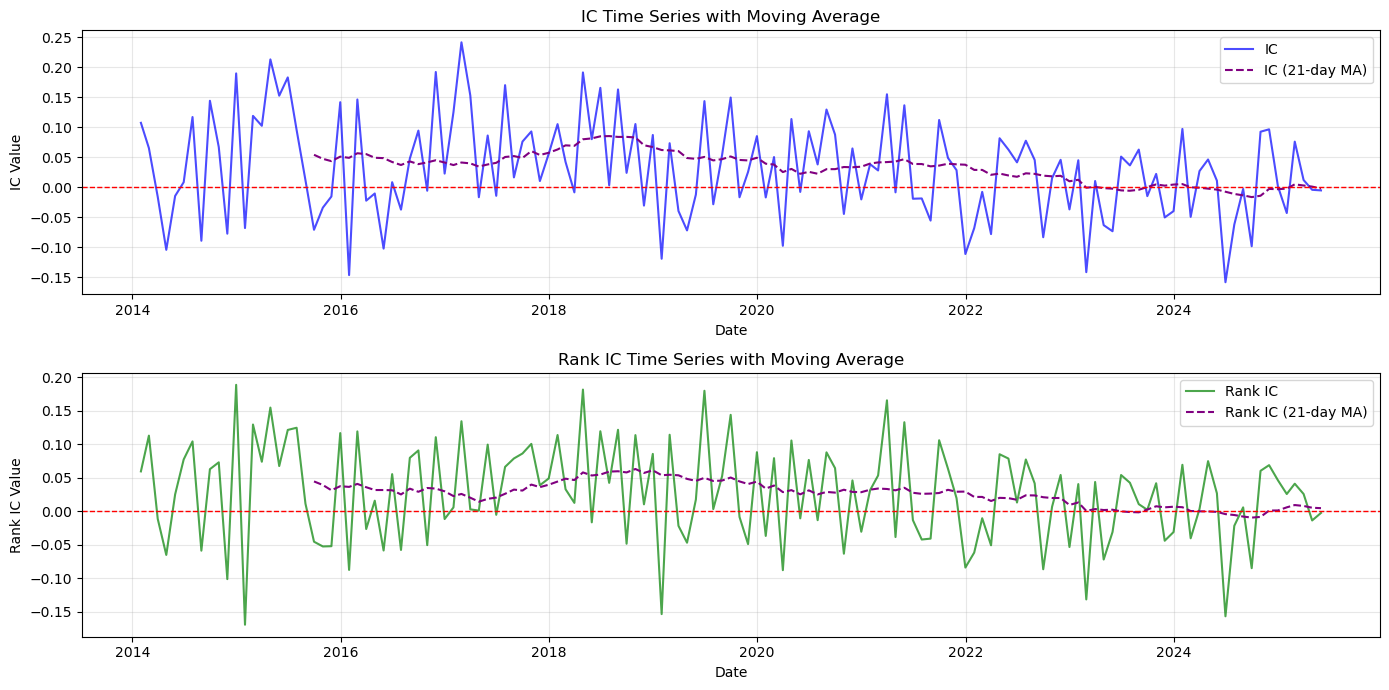

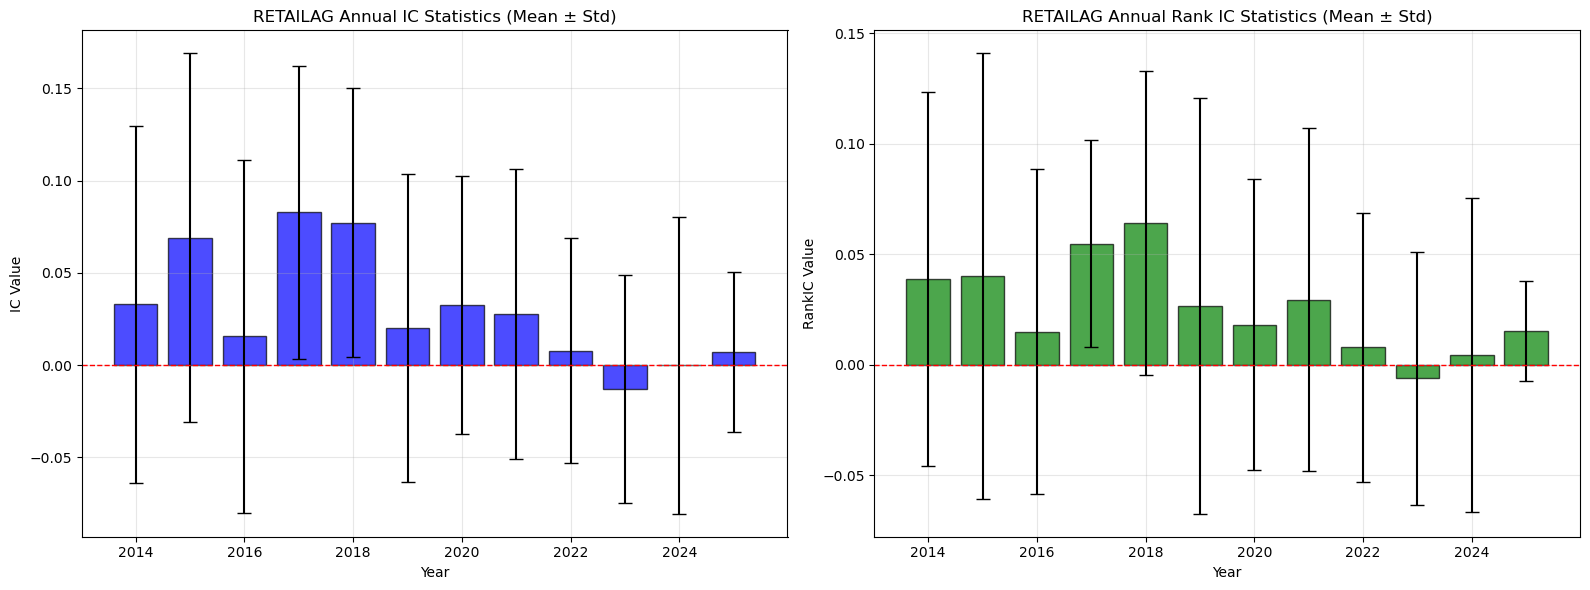

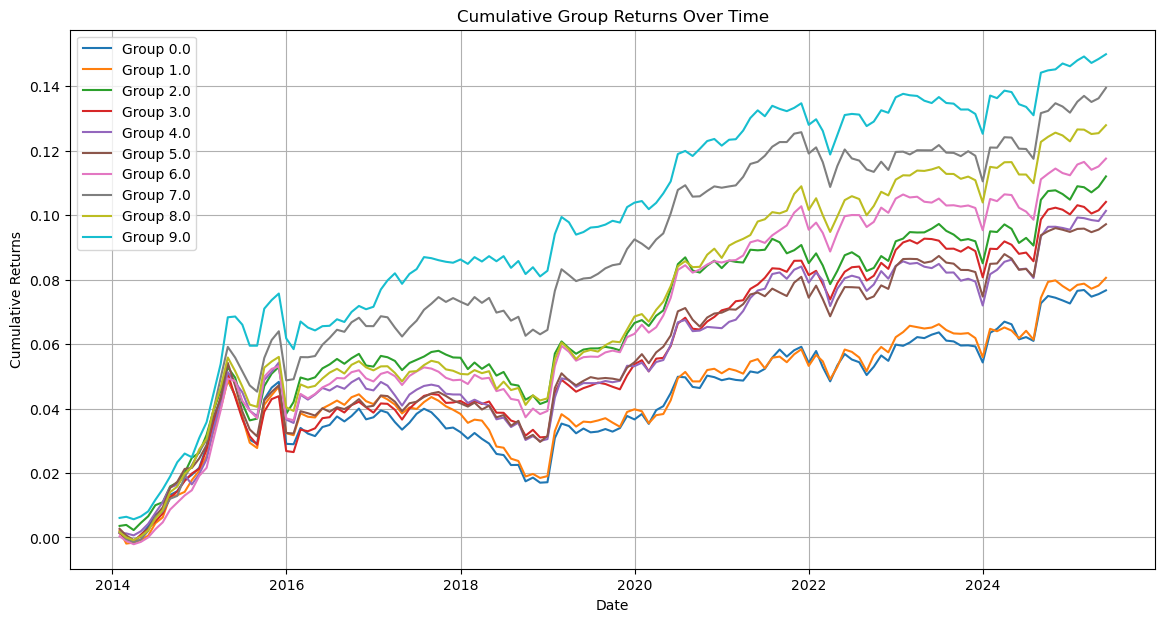

Long position: Group 9.0
Short position: Group 0.0


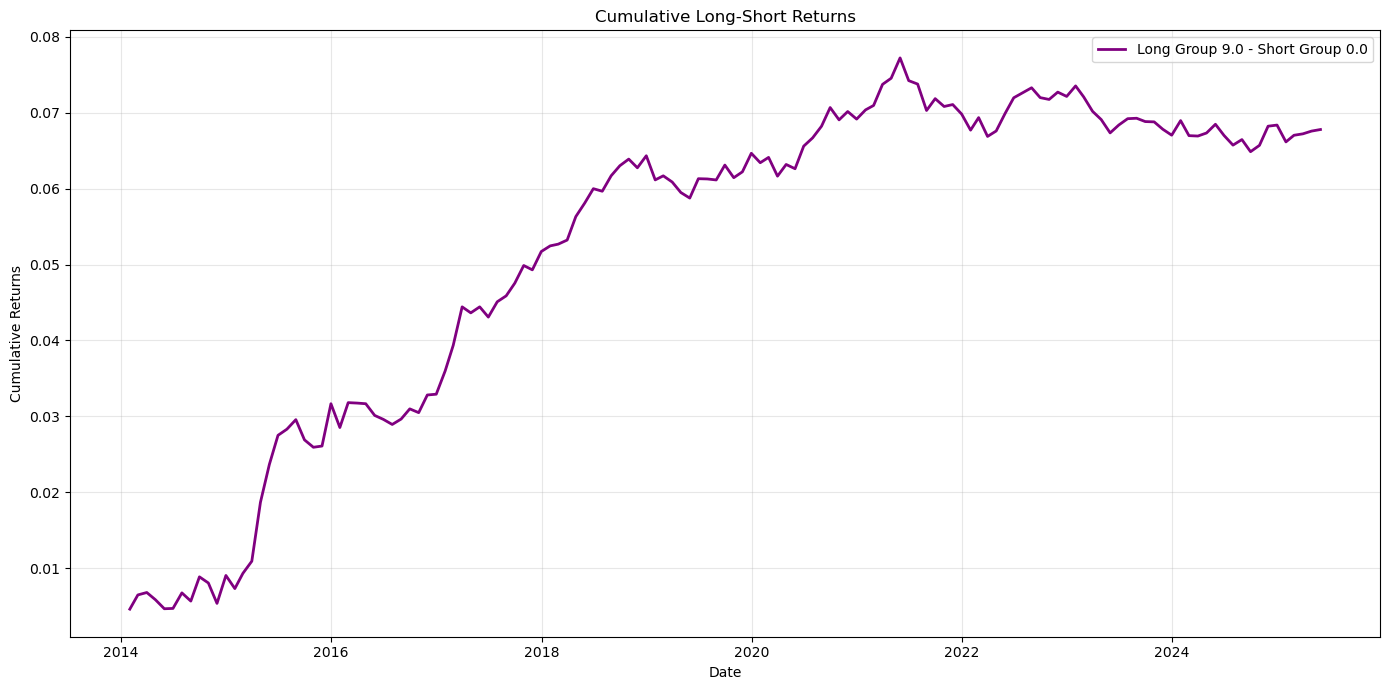

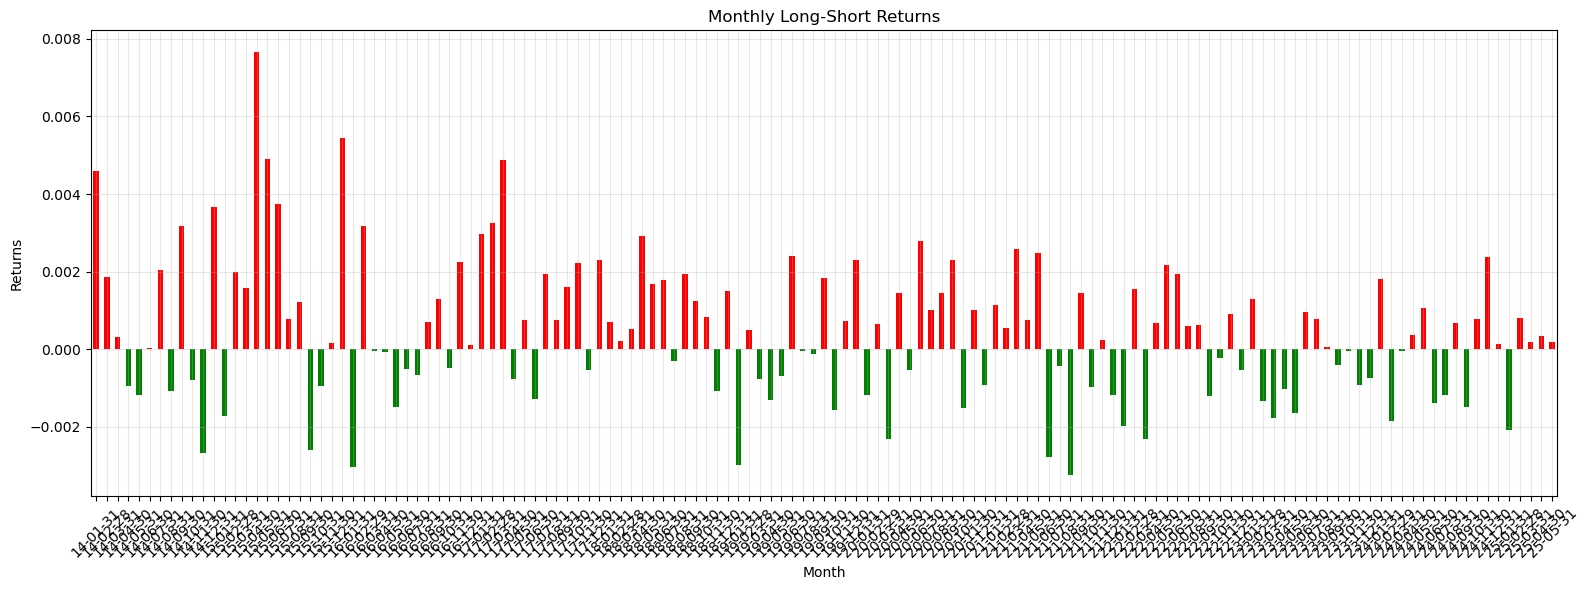

------------------------------------------------------------
Annual Return: 12.11%
Annual Volatility: 2.91%
Sharpe Ratio: 4.17
Max Drawdown: 1.24%
------------------------------------------------------------


In [10]:
# 因子效果测试


RETAILAG = M_lagged_corr.copy()
RETAILAG.name = 'RETAILAG'

ic_lagged, rankic_lagged, group_ret_lagged = simple_factor_test(RETAILAG, ret_close, 10)


plot_factor_performance(RETAILAG, ret_close, ic_lagged, rankic_lagged, group_ret_lagged)

